# desisky Quickstart Guide

This notebook demonstrates how to:
1. Load pre-trained models
2. Download and load DESI sky spectra data
3. Use enriched metadata (V-band, ECLIPSE_FRAC)
4. Load moon-contaminated subset
5. Run inference
6. Visualize results

In [1]:
import desisky
from desisky.data import SkySpecVAC
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Load Pre-trained Broadband Model

The broadband model predicts surface brightness in V, g, r, and z photometric bands from observational metadata.

In [2]:
# Load the pre-trained broadband model
model, meta = desisky.io.load_model("broadband")

print("Model loaded successfully!")
print(f"Architecture: {meta['arch']}")
print(f"Input features: {meta['arch']['in_size']}")
print(f"Output bands: {meta['arch']['out_size']} (V, g, r, z)")

Model loaded successfully!
Architecture: {'depth': 5, 'in_size': 6, 'out_size': 4, 'width_size': 128}
Input features: 6
Output bands: 4 (V, g, r, z)


## 2. Download DESI Sky Spectra Data

The `SkySpecVAC` class provides a PyTorch-like interface for downloading and loading the DESI DR1 sky spectra Value-Added Catalog.

The dataset includes:
- **9,176 sky spectra** with 7,781 wavelength points each
- **Metadata** including observing conditions (airmass, seeing, sky brightness, moon/sun positions, etc.)

First run will download ~274 MB from DESI public data release.

In [3]:
# Download and load the VAC
# Set download=True to download if not already present
# SHA-256 verification ensures data integrity
vac = SkySpecVAC(version="v1.0", download=True, verify=True)

print(f"Data file location: {vac.filepath()}")

Data file location: /home/mdowicz/.desisky/data/dr1/sky_spectra_vac_v1.fits


In [4]:
# Load wavelength, flux, and metadata (basic, no enrichment)
wavelength, flux, metadata = vac.load()

print(f"Wavelength shape: {wavelength.shape}")  # (7781,)
print(f"Flux shape: {flux.shape}")              # (9176, 7781)
print(f"Metadata shape: {metadata.shape}")      # (9176, 22)
print(f"\nAvailable metadata columns:\n{list(metadata.columns)}")

Wavelength shape: (7781,)
Flux shape: (9176, 7781)
Metadata shape: (9176, 22)

Available metadata columns:
['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'MJD', 'EXPTIME', 'AIRMASS', 'EBV', 'SEEING_ETC', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC', 'MOONFRAC', 'MOONALT', 'MOONSEP', 'SUNALT', 'SUNSEP', 'OBSALT', 'OBSAZ']


## 3. Load with Enriched Metadata (NEW!)

Use `enrich=True` to automatically compute:
- **SKY_MAG_V_SPEC**: V-band magnitude from spectra
- **ECLIPSE_FRAC**: Lunar eclipse umbral coverage fraction

This requires optional dependencies: `speclite` and `astropy`

In [5]:
# Load with enrichment (computes V-band and ECLIPSE_FRAC)
# This may take ~30 seconds on first run
wave_e, flux_e, meta_e = vac.load(enrich=True)

print(f"Enriched metadata shape: {meta_e.shape}")  # (9176, 24)
print(f"\nNew columns added:")
print(f"  - SKY_MAG_V_SPEC: {('SKY_MAG_V_SPEC' in meta_e.columns)}")
print(f"  - ECLIPSE_FRAC: {('ECLIPSE_FRAC' in meta_e.columns)}")

# Show summary statistics
print(f"\nV-band magnitude range: [{meta_e['SKY_MAG_V_SPEC'].min():.2f}, {meta_e['SKY_MAG_V_SPEC'].max():.2f}]")
print(f"Observations during eclipses: {(meta_e['ECLIPSE_FRAC'] > 0).sum()}")

Enriched metadata shape: (9176, 24)

New columns added:
  - SKY_MAG_V_SPEC: True
  - ECLIPSE_FRAC: True

V-band magnitude range: [16.84, 22.09]
Observations during eclipses: 15


In [6]:
# Examine enriched metadata
meta_e[['NIGHT', 'MOONFRAC', 'MOONALT', 'SKY_MAG_V_SPEC', 'ECLIPSE_FRAC']].head(10)

,NIGHT,MOONFRAC,MOONALT,SKY_MAG_V_SPEC,ECLIPSE_FRAC
0,20201214,0.003541,-42.537561,21.534391,0.0
1,20201214,0.003737,-46.523326,21.536032,0.0
2,20201214,0.003931,-50.359741,21.540858,0.0
3,20201214,0.004131,-54.199713,21.547872,0.0
4,20201214,0.004586,-62.611068,21.484881,0.0
5,20201214,0.004944,-68.839494,21.582853,0.0
6,20201214,0.006084,-82.726069,21.525909,0.0
7,20201214,0.006342,-81.837170,21.496019,0.0
8,20201214,0.006592,-79.440044,21.513903,0.0
9,20201214,0.006846,-76.308258,21.523243,0.0


## 4. Load Data Subsets (NEW!)

The VAC provides three subset methods for different observing conditions:

1. **Dark Time** (`load_dark_time()`): Non-contaminated observations
   - SUNALT < -20 (Sun well below horizon)
   - MOONALT < -5 (Moon below horizon)
   - TRANSPARENCY_GFA > 0 (valid measurements)

2. **Sun Contaminated** (`load_sun_contaminated()`): Twilight observations
   - SUNALT > -20 (Sun near or above horizon)
   - MOONALT <= -5 (Moon below horizon)
   - MOONSEP <= 110 (Sun-Moon separation)
   - TRANSPARENCY_GFA > 0

3. **Moon Contaminated** (`load_moon_contaminated()`): Moon-bright observations
   - SUNALT < -20 (nighttime)
   - MOONALT > 5 (Moon above horizon)
   - MOONFRAC > 0.5 (Moon >50% illuminated)
   - MOONSEP <= 90 (Moon within 90 degrees)
   - TRANSPARENCY_GFA > 0

All subset methods include enrichment by default (`enrich=True`).

In [ ]:
# Load all three subsets
wave_dark, flux_dark, meta_dark = vac.load_dark_time()
wave_sun, flux_sun, meta_sun = vac.load_sun_contaminated()
wave_moon, flux_moon, meta_moon = vac.load_moon_contaminated()

print("Dataset Subset Summary:")
print(f"  Total observations: 9176")
print(f"  Dark time:          {len(meta_dark):4d} ({100*len(meta_dark)/9176:4.1f}%)")
print(f"  Sun contaminated:   {len(meta_sun):4d} ({100*len(meta_sun)/9176:4.1f}%)")
print(f"  Moon contaminated:  {len(meta_moon):4d} ({100*len(meta_moon)/9176:4.1f}%)")
print(f"\nAll subsets include enrichment: {('ECLIPSE_FRAC' in meta_moon.columns)}")

In [ ]:
# Verify filtering criteria for each subset
print("Dark time criteria verification:")
print(f"  SUNALT < -20: {(meta_dark['SUNALT'] < -20).all()}")
print(f"  MOONALT < -5: {(meta_dark['MOONALT'] < -5).all()}")
print(f"  TRANSPARENCY_GFA > 0: {(meta_dark['TRANSPARENCY_GFA'] > 0).all()}")

print("\nSun contaminated criteria verification:")
print(f"  SUNALT > -20: {(meta_sun['SUNALT'] > -20).all()}")
print(f"  MOONALT <= -5: {(meta_sun['MOONALT'] <= -5).all()}")
print(f"  MOONSEP <= 110: {(meta_sun['MOONSEP'] <= 110).all()}")

print("\nMoon contaminated criteria verification:")
print(f"  SUNALT < -20: {(meta_moon['SUNALT'] < -20).all()}")
print(f"  MOONALT > 5: {(meta_moon['MOONALT'] > 5).all()}")
print(f"  MOONFRAC > 0.5: {(meta_moon['MOONFRAC'] > 0.5).all()}")
print(f"  MOONSEP <= 90: {(meta_moon['MOONSEP'] <= 90).all()}")

## 5. Visualize Sky Spectra

Plot some example spectra to see what the data looks like.

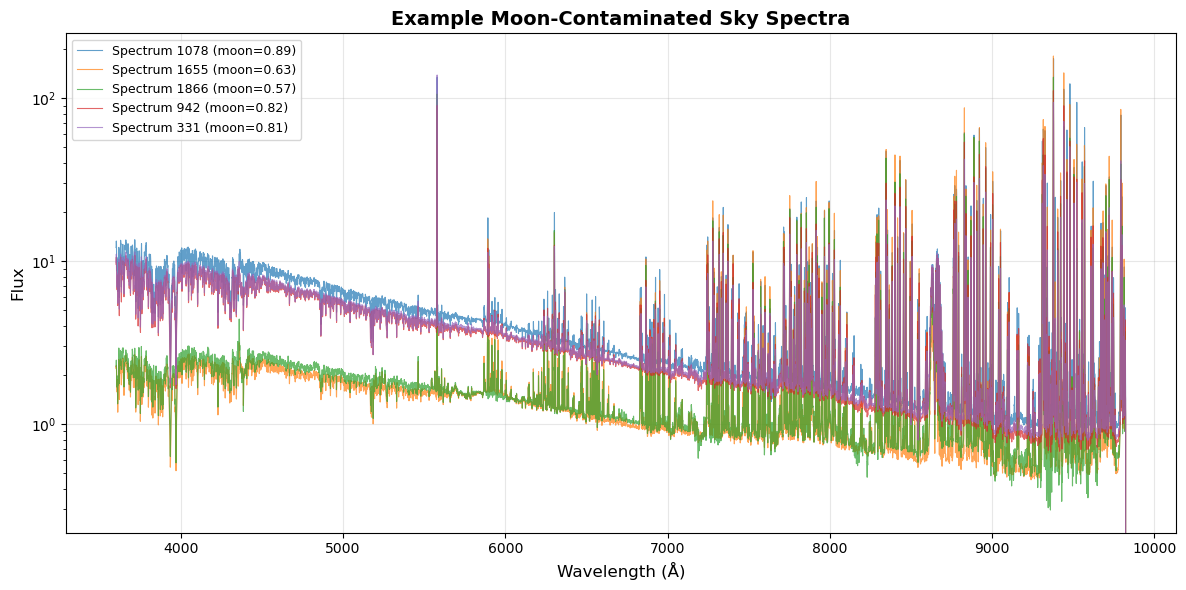

In [9]:
# Plot a few random spectra from moon subset
fig, ax = plt.subplots(figsize=(12, 6))

# Select 5 random spectra
np.random.seed(42)
indices = np.random.choice(flux_moon.shape[0], size=5, replace=False)

for idx in indices:
    moon_frac = meta_moon.iloc[idx]['MOONFRAC']
    ax.plot(wave_moon, flux_moon[idx], alpha=0.7, linewidth=0.8, 
            label=f"Spectrum {idx} (moon={moon_frac:.2f})")

ax.set_xlabel("Wavelength (Å)", fontsize=12)
ax.set_ylabel("Flux", fontsize=12)
ax.set_title("Example Moon-Contaminated Sky Spectra", fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Observing Conditions Distribution

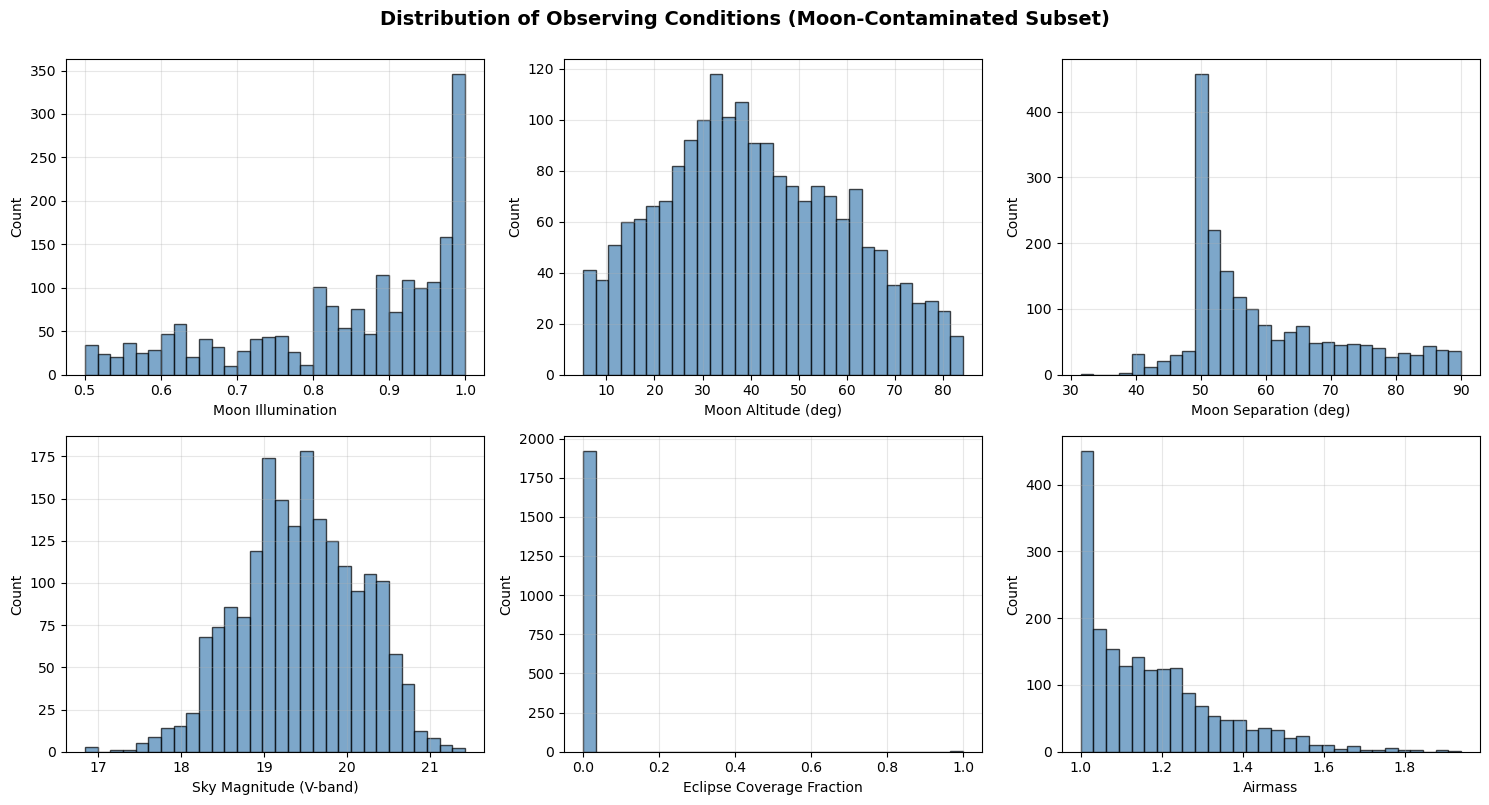

In [10]:
# Plot distributions of key observing parameters
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

params = [
    ('MOONFRAC', 'Moon Illumination'),
    ('MOONALT', 'Moon Altitude (deg)'),
    ('MOONSEP', 'Moon Separation (deg)'),
    ('SKY_MAG_V_SPEC', 'Sky Magnitude (V-band)'),
    ('ECLIPSE_FRAC', 'Eclipse Coverage Fraction'),
    ('AIRMASS', 'Airmass')
]

for i, (col, label) in enumerate(params):
    axes[i].hist(meta_moon[col], bins=30, alpha=0.7, edgecolor='black', color='steelblue')
    axes[i].set_xlabel(label, fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Distribution of Observing Conditions (Moon-Contaminated Subset)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Model Inference Example

Run the broadband model on moon-contaminated observations.

The model expects these 6 input features:
- MOONSEP, OBSALT, MOONALT, MOONFRAC, TRANSPARENCY_GFA, ECLIPSE_FRAC

In [11]:
# Prepare input features for the model
INPUT_FEATURES = ['MOONSEP', 'OBSALT', 'MOONALT', 'MOONFRAC', 'TRANSPARENCY_GFA', 'ECLIPSE_FRAC']

# Clean data (remove any rows with NaN in required columns)
clean_meta = meta_moon.dropna(subset=INPUT_FEATURES)

print(f"Clean subset size: {len(clean_meta)} observations")
print(f"Input features: {INPUT_FEATURES}")

# Convert to JAX array
X = jnp.asarray(clean_meta[INPUT_FEATURES].to_numpy(dtype=np.float32))
print(f"\nInput array shape: {X.shape}")  # (n_obs, 6)

Clean subset size: 1931 observations
Input features: ['MOONSEP', 'OBSALT', 'MOONALT', 'MOONFRAC', 'TRANSPARENCY_GFA', 'ECLIPSE_FRAC']

Input array shape: (1931, 6)


In [12]:
# Run single observation inference
single_input = X[0]
single_pred = model(single_input)

print(f"Single input shape: {single_input.shape}")  # (6,)
print(f"Single output shape: {single_pred.shape}")  # (4,)
print(f"\nPredicted magnitudes (V, g, r, z): {single_pred}")

Single input shape: (6,)
Single output shape: (4,)

Predicted magnitudes (V, g, r, z): [20.897463 21.105093 20.862629 19.55945 ]


## 8. Batch Inference

Process all observations at once using JAX's vectorization.

In [13]:
# Vectorize the model for batch processing
batch_model = jax.vmap(model)

# Run batch inference
batch_predictions = batch_model(X)

print(f"Batch input shape: {X.shape}")  # (n_obs, 6)
print(f"Batch output shape: {batch_predictions.shape}")  # (n_obs, 4)
print(f"\nFirst 5 predictions (V, g, r, z):\n{batch_predictions[:5]}")

Batch input shape: (1931, 6)
Batch output shape: (1931, 4)

First 5 predictions (V, g, r, z):
[[20.898193 21.105974 20.863525 19.560244]
 [20.826706 21.017246 20.804897 19.552406]
 [20.90461  21.125511 20.860826 19.537529]
 [20.247412 20.365385 20.252508 19.277664]
 [20.186125 20.314304 20.166082 19.221905]]


## 9. Compare Predictions vs Observations

Visualize how well the model predicts V-band magnitudes.

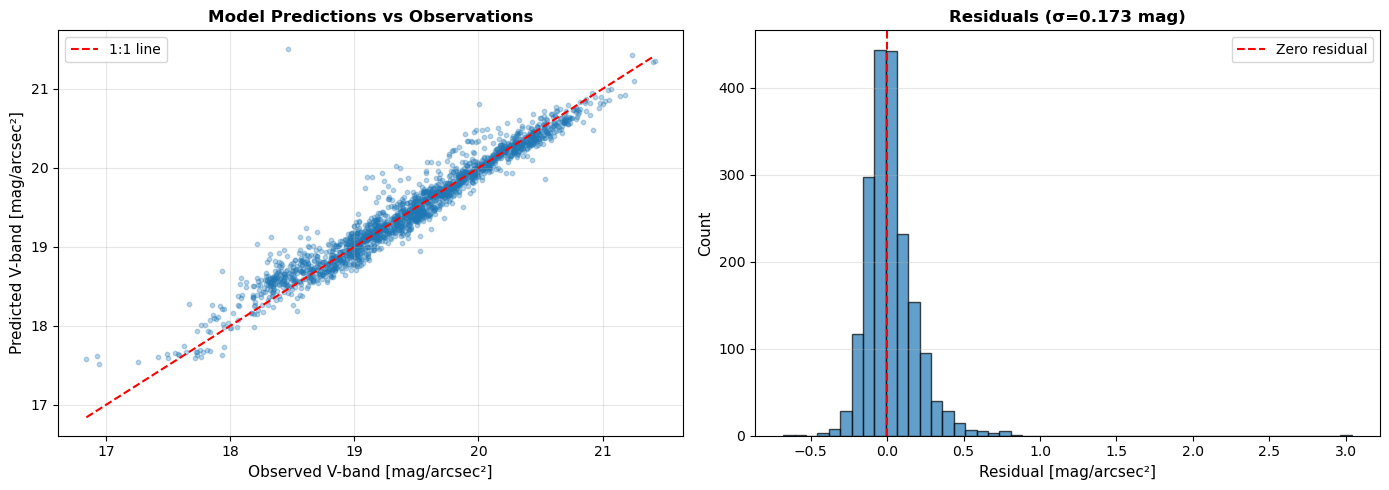


Model performance:
  Mean residual: 0.022 mag
  RMS residual: 0.174 mag


In [14]:
# Extract V-band predictions and observations
v_pred = batch_predictions[:, 0]  # V-band is first output
v_obs = clean_meta['SKY_MAG_V_SPEC'].values

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1.scatter(v_obs, v_pred, alpha=0.3, s=10)
ax1.plot([v_obs.min(), v_obs.max()], [v_obs.min(), v_obs.max()], 
         'r--', label='1:1 line')
ax1.set_xlabel('Observed V-band [mag/arcsec²]', fontsize=11)
ax1.set_ylabel('Predicted V-band [mag/arcsec²]', fontsize=11)
ax1.set_title('Model Predictions vs Observations', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residuals histogram
residuals = v_pred - v_obs
ax2.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
ax2.axvline(0, color='r', linestyle='--', label='Zero residual')
ax2.set_xlabel('Residual [mag/arcsec²]', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title(f'Residuals (σ={residuals.std():.3f} mag)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nModel performance:")
print(f"  Mean residual: {residuals.mean():.3f} mag")
print(f"  RMS residual: {np.sqrt((residuals**2).mean()):.3f} mag")

## Summary

This notebook demonstrated:
- ✅ Loading pre-trained models with `desisky.io.load_model()`
- ✅ Downloading DESI data with automatic verification
- ✅ **NEW:** Loading enriched metadata with V-band and ECLIPSE_FRAC
- ✅ **NEW:** Filtering moon-contaminated subset for broadband model
- ✅ Visualizing emission lines and observing conditions
- ✅ Running model inference (single and batch)
- ✅ Comparing predictions vs observations